# Rice Type Classification using PyTorch Neural Network

This notebook demonstrates binary classification of rice types using a simple neural network.

## Dataset
- **Source**: Kaggle Rice Type Classification Dataset
- **Features**: 10 morphological features (Area, MajorAxisLength, MinorAxisLength, etc.)
- **Target**: Binary classification (0 or 1)

## Architecture
- **Model**: 3-layer feedforward neural network
- **Layers**: 10 → 20 → 10 → 1
- **Activation**: Sigmoid (for binary classification)
- **Loss**: Binary Cross Entropy with Logits

## 1. Setup and Data Download

In [1]:
!pip install opendatasets --quiet

import opendatasets as od

od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


## 2. Import Libraries

In [2]:
# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Data Processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 3. Load and Explore Data

In [3]:
# Load the dataset
df = pd.read_csv("./rice-type-classification/riceClassification.csv")

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (18185, 12)

First few rows:


,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
# Check for missing values and data types
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nClass distribution:")
print(df['Class'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB
None

Missing values:
id                 0
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent        

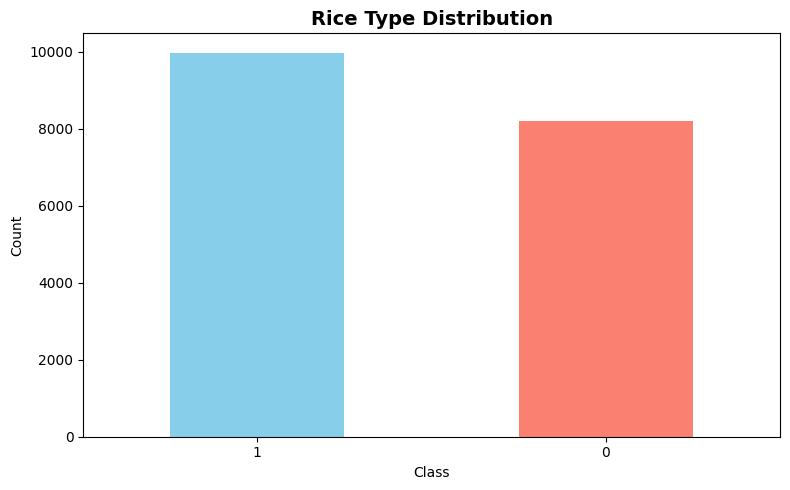

In [5]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Rice Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [6]:
# Separate features and target
# Drop 'id' column as it's not a useful feature
X = df.drop(['id', 'Class'], axis=1).values
y = df['Class'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train and test sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y  # Maintain class distribution in splits
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Features shape: (18185, 10)
Target shape: (18185,)

Training samples: 12729
Testing samples: 5456


In [7]:
# Normalize features using StandardScaler
# This is CRUCIAL for neural network training!
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use same scaling as training data

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).view(-1, 1)  # Reshape to column vector
y_test = torch.FloatTensor(y_test).view(-1, 1)

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training features shape: torch.Size([12729, 10])
Training labels shape: torch.Size([12729, 1])


## 5. Define the Neural Network Model

In [8]:
class RiceClassifier(nn.Module):
    """
    Binary classification neural network for rice type prediction.
    
    Architecture:
    - Input layer: 10 features
    - Hidden layer 1: 20 neurons with ReLU activation
    - Hidden layer 2: 10 neurons with ReLU activation
    - Output layer: 1 neuron (binary classification)
    """
    
    def __init__(self):
        super(RiceClassifier, self).__init__()
        
        # Define network layers
        self.layer1 = nn.Linear(10, 20)   # Input to first hidden layer
        self.layer2 = nn.Linear(20, 10)   # First to second hidden layer
        self.layer3 = nn.Linear(10, 1)    # Second hidden to output
        
        # Activation functions
        self.relu = nn.ReLU()             # For hidden layers
        self.sigmoid = nn.Sigmoid()       # For output (binary classification)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 10)
            
        Returns:
            Output tensor of shape (batch_size, 1) with values in [0, 1]
        """
        x = self.relu(self.layer1(x))     # First hidden layer
        x = self.relu(self.layer2(x))     # Second hidden layer
        x = self.sigmoid(self.layer3(x))  # Output with sigmoid activation
        return x

In [9]:
# Initialize the model
model = RiceClassifier().to(device)

# Display model architecture
print("Model Architecture:")
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal trainable parameters: {total_params:,}")

Model Architecture:
RiceClassifier(
  (layer1): Linear(in_features=10, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total trainable parameters: 441


## 6. Training Setup

In [10]:
# Loss function: Binary Cross Entropy
# Since we're using sigmoid in the model, we use BCELoss (not BCEWithLogitsLoss)
loss_fn = nn.BCELoss()

# Optimizer: Adam (generally better than SGD for this type of problem)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001  # Learning rate
)

print(f"Loss function: {loss_fn}")
print(f"Optimizer: {optimizer}")

Loss function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 7. Train the Model

In [11]:
# Training configuration
epochs = 300

# Move data to device (GPU if available)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Track losses for visualization
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...\n")

for epoch in range(epochs):
    # ============ TRAINING MODE ============
    model.train()
    
    # Forward pass: compute predictions
    y_pred = model(X_train)
    
    # Compute loss
    loss = loss_fn(y_pred, y_train)
    
    # Backward pass: compute gradients
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute new gradients
    optimizer.step()       # Update weights
    
    # Calculate training accuracy
    train_preds = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    train_acc = (train_preds == y_train).float().mean()
    
    # ============ EVALUATION MODE ============
    model.eval()
    with torch.inference_mode():  # Disable gradient computation for efficiency
        # Test set predictions
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred, y_test)
        
        # Calculate test accuracy
        test_preds = (y_test_pred > 0.5).float()
        test_acc = (test_preds == y_test).float().mean()
    
    # Store metrics
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_acc.item())
    test_accuracies.append(test_acc.item())
    
    # Print progress every 30 epochs
    if epoch % 30 == 0:
        print(f"Epoch {epoch:3d} | "
              f"Train Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

print("\n✓ Training completed!")

Starting training...

Epoch   0 | Train Loss: 0.6882 | Train Acc: 0.4509 | Test Loss: 0.6862 | Test Acc: 0.4509
Epoch  30 | Train Loss: 0.6215 | Train Acc: 0.7464 | Test Loss: 0.6187 | Test Acc: 0.7889
Epoch  60 | Train Loss: 0.5307 | Train Acc: 0.9792 | Test Loss: 0.5261 | Test Acc: 0.9837
Epoch  90 | Train Loss: 0.4013 | Train Acc: 0.9818 | Test Loss: 0.3949 | Test Acc: 0.9848
Epoch 120 | Train Loss: 0.2565 | Train Acc: 0.9821 | Test Loss: 0.2490 | Test Acc: 0.9857
Epoch 150 | Train Loss: 0.1480 | Train Acc: 0.9834 | Test Loss: 0.1414 | Test Acc: 0.9863
Epoch 180 | Train Loss: 0.0935 | Train Acc: 0.9840 | Test Loss: 0.0877 | Test Acc: 0.9866
Epoch 210 | Train Loss: 0.0697 | Train Acc: 0.9842 | Test Loss: 0.0640 | Test Acc: 0.9874
Epoch 240 | Train Loss: 0.0584 | Train Acc: 0.9845 | Test Loss: 0.0526 | Test Acc: 0.9883
Epoch 270 | Train Loss: 0.0522 | Train Acc: 0.9846 | Test Loss: 0.0463 | Test Acc: 0.9885

✓ Training completed!


## 8. Visualize Training Progress

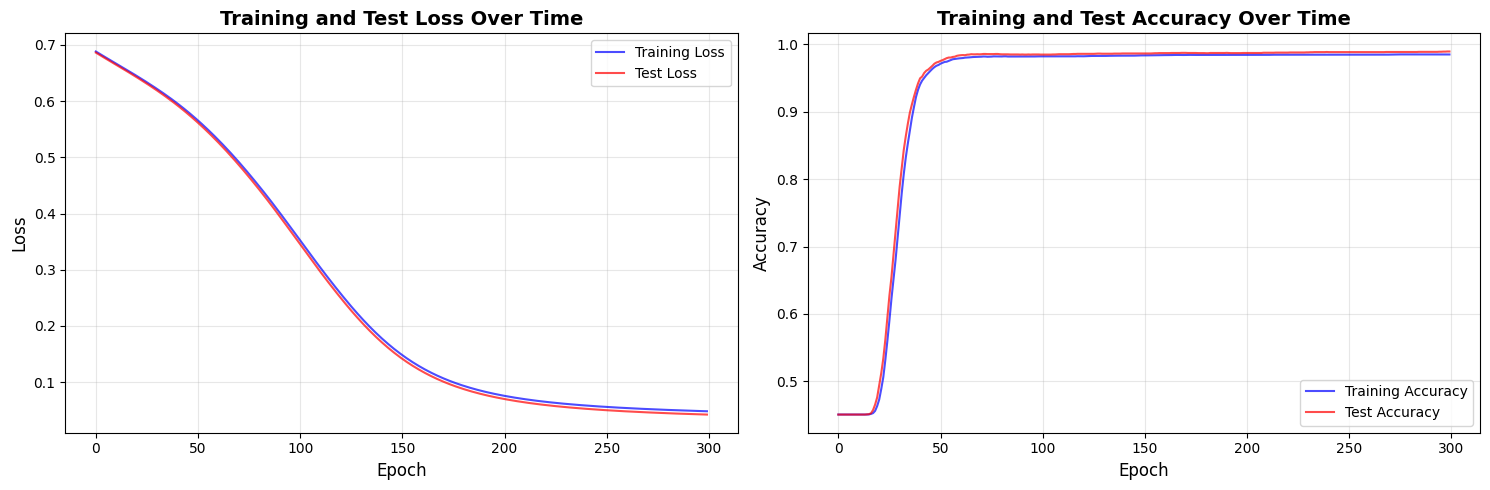


Final Training Accuracy: 0.9848 (98.48%)
Final Test Accuracy: 0.9892 (98.92%)


In [12]:
# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
ax1.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Test Loss Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_accuracies, label='Training Accuracy', color='blue', alpha=0.7)
ax2.plot(test_accuracies, label='Test Accuracy', color='red', alpha=0.7)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Test Accuracy Over Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {train_accuracies[-1]:.4f} ({train_accuracies[-1]*100:.2f}%)")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f} ({test_accuracies[-1]*100:.2f}%)")

## 9. Model Evaluation

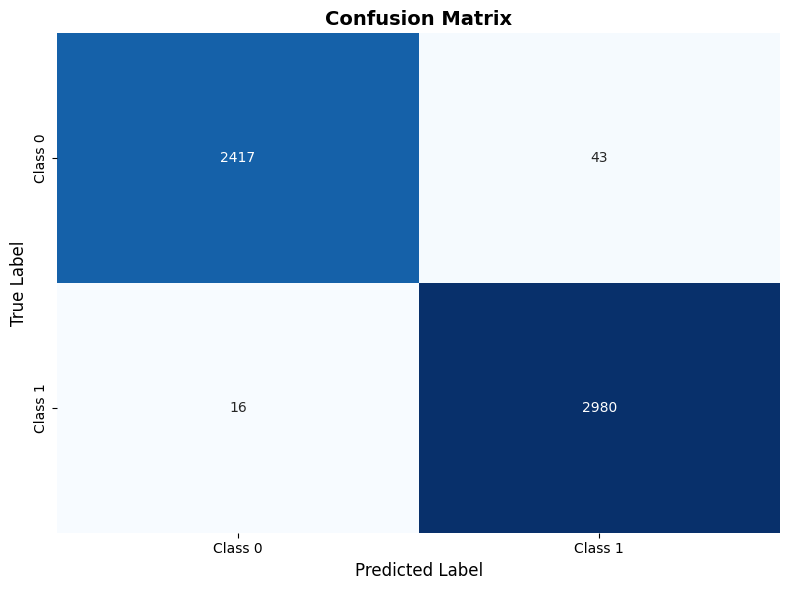


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99      2460
     Class 1       0.99      0.99      0.99      2996

    accuracy                           0.99      5456
   macro avg       0.99      0.99      0.99      5456
weighted avg       0.99      0.99      0.99      5456



In [13]:
# Get final predictions on test set
model.eval()
with torch.inference_mode():
    y_test_pred = model(X_test)
    y_test_pred_binary = (y_test_pred > 0.5).float()

# Convert to numpy for sklearn metrics
y_test_np = y_test.cpu().numpy()
y_pred_np = y_test_pred_binary.cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=['Class 0', 'Class 1']))

## 10. Save the Model (Optional)

In [14]:
# Save model weights
torch.save(model.state_dict(), 'rice_classifier.pth')
print("✓ Model saved as 'rice_classifier.pth'")

# To load the model later:
# model = RiceClassifier()
# model.load_state_dict(torch.load('rice_classifier.pth'))
# model.eval()

✓ Model saved as 'rice_classifier.pth'
